In [13]:
import numpy as np
import matplotlib.pyplot as plt
from PyCo.SolidMechanics import PeriodicFFTElasticHalfSpace, FreeFFTElasticHalfSpace
from PyCo.Topography import Topography, make_sphere

In [46]:

nx = 16
ny = 16
sx = 2 * np.pi
sy = 2 * np.pi

R = 5

topography = make_sphere(R, (nx, ny), (sx,sy))
heights = topography.heights()

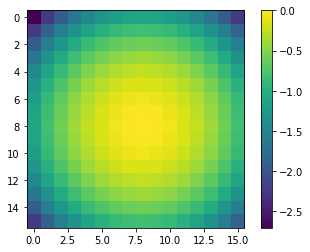

In [47]:
plt.colorbar(plt.imshow(heights))

In [48]:
substrate=FreeFFTElasticHalfSpace((nx, ny), young = 100 ,size= (sx, sy))

In [95]:
penetration = 0
external_force = None

offset = 0.5
sigma0 =1
h0  = 0.2
sigma0 *= topography.area_per_pt
nb_surface_pts = np.prod(topography.resolution)

# initial guess for p_r

u_r = np.zeros((2*nx, 2*ny))
heights = np.ones((2*nx, 2*ny)) * (-1e18)
heights[:nx, :ny] = topography.heights()
u_r = np.maximum(heights + offset,0)
#p_r = substrate.evaluate_force(u_r)
p_r = np.ones_like(u_r)*  2* sigma0

# initialisations
delta = 0
G_old = 1.0
tau = 0.0
t_r = np.zeros_like(u_r)

it = 1
pnp= np

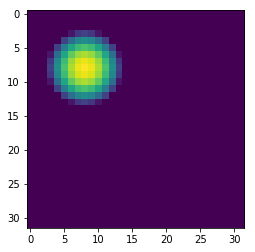

In [96]:
plt.imshow(u_r)

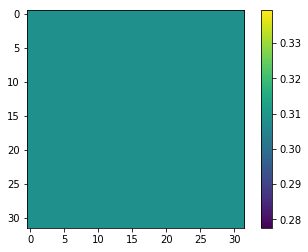

In [97]:
plt.colorbar(plt.imshow(p_r))

1
A_cg 0
offset: 0.5
rms_pen 0.0
max_pen 0.5
tau 0.0
N_overlap 97.0
computed_force before balance -21.12712192108191
computed_force -21.12712192108191
max_pen 0.5


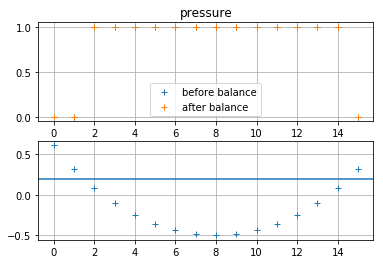

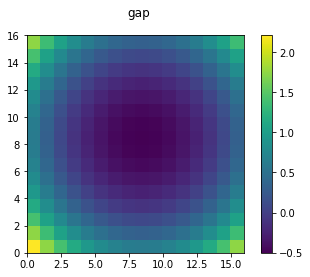

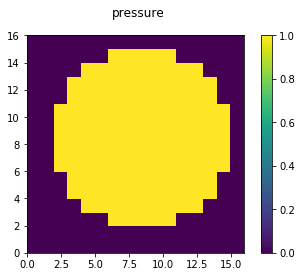

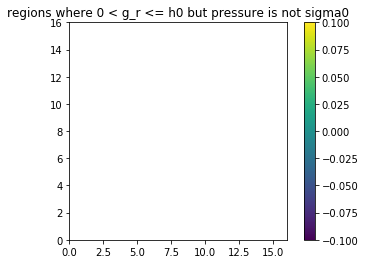

In [98]:
comp_slice = [slice(0,max(0,min(substrate.resolution[i] - substrate.subdomain_location[i],substrate.subdomain_resolution[i])))
                  for i in range(substrate.dim)]

comp_mask = np.zeros(substrate.subdomain_resolution, dtype=bool)
comp_mask[tuple(comp_slice)] = True

figpc, (axpc, axgc) = plt.subplots(2,1)   
axpc.set_title("pressure")
axpc.grid()
axgc.grid()

figg, axg = plt.subplots()
axg.set_aspect(1)
figg.suptitle("gap")

print(it)

c_r = p_r < sigma0 # = Ic in Bazrafshan

A_cg = pnp.sum(c_r*1)
print("A_cg {}".format(A_cg))
# Compute deformation

####

u_r = substrate.evaluate_disp((p_r<=sigma0) * p_r)
# Compute gap
g_r = u_r- heights

if external_force is not None:
    offset = 0
    if A_cg > 0:
        offset = pnp.sum(g_r[c_r]) / A_cg
g_r -= offset

print("offset: {}".format(offset))


axgc.plot(g_r[:nx, ny//2], "+")
axgc.axhline(h0)
plt.colorbar(axg.pcolormesh(g_r[:nx, :ny] , rasterized = True))

########### Search direction
# Compute G = sum(g*g) (over contact area only)
G = pnp.sum(c_r*g_r*g_r)

if delta > 0 and G_old > 0: # CG step
    t_r = c_r*(g_r + delta*(G/G_old)*t_r)
else: # steepest descend step (CG restart)
    t_r = c_r*g_r
    
r_r = substrate.evaluate_disp(t_r)
#bazrafshan
#r_r -= pnp.sum(r_r[c_r]) / A_cg

########## Step size
tau = 0.0
if A_cg > 0:
    # tau = -sum(g*t)/sum(r*t) where sum is only over contact region
    x = -pnp.sum(c_r*r_r*t_r)
    if x > 0.0:
        tau = pnp.sum(c_r*g_r*t_r)/x
    else:
        G = 0.0

# Compute root-mean square penetration, max penetration and max force
# difference between the steps
if A_cg > 0:
    rms_pen = np.sqrt(G/A_cg)
else:
    rms_pen = np.sqrt(G)
max_pen = max(0.0, pnp.max(-g_r))
print("rms_pen {}".format(rms_pen))
print("max_pen {}".format(max_pen))        
########## Do step
print("tau {}".format(tau))
p_r += tau*c_r*t_r

######### Projection on feasible set
p_r[p_r>sigma0] = sigma0
#p_r[np.logical_and] = sigma0 # not in bas, but I suggest to add new points to sigma0
######### Remove points with gap greater then h0 from interacting points
outside_mask = np.logical_and(g_r > h0, p_r >= 0) # bas
#outside_mask = g_r > h0
p_r[outside_mask] = 1000 * sigma0

######### Overlap Area: points to be added to the part where the gap is minimized
#overlap_mask = np.logical_and(g_r < 0, p_r > 0) # bazrafshan
overlap_mask = np.logical_and(g_r < 0, p_r >=sigma0) 
# points with p_r < sigma 0 are already in the contact area

N_overlap = pnp.sum(overlap_mask*1.)
print("N_overlap {}".format(N_overlap))
if N_overlap > 0:
    delta = 0. # this will restart the conjugate gradient with a steepest descent
    if tau != 0
    p_r[overlap_mask] += tau * g_r[overlap_mask]
else: 
    delta = 1.


axpc.plot((p_r * (p_r <= sigma0))[:nx, ny//2] / topography.area_per_pt, "+", label = "before balance")
######### Impose force balance
print("computed_force before balance {}".format(- pnp.sum(p_r * (p_r <= sigma0) )))
if external_force is not None:
    contact_mask = p_r < sigma0 # not including the Dugdale zone, because there the pressure should not change
    N_contact= pnp.sum(contact_mask)

    contact_psum = pnp.sum(p_r[contact_mask])
    print(contact_psum)
    N_Dugdale = pnp.sum(p_r == sigma0)
    print("N_Dugdale: {}".format(N_Dugdale))
    if contact_psum != 0:
        fact = ( ( - external_force - sigma0 * N_Dugdale) + N_contact * sigma0) \
               / (contact_psum + N_contact * sigma0)
        p_r[contact_mask] = fact * (p_r[contact_mask]  + sigma0) - sigma0
    else:
        # add constant pressure everywhere
        p_r += (-external_force - sigma0 * N_Dugdale)/nb_surface_pts*np.ones_like(p_r)
        #p_r[pad_mask] = 0.0
print("computed_force {}".format(- pnp.sum(p_r * (p_r <= sigma0) )))
        
figp, axp = plt.subplots()
axp.set_aspect(1)
figp.suptitle("pressure")
plt.colorbar(axp.pcolormesh(p_r[:nx, :ny] * (p_r[:nx, :ny] <= sigma0) / topography.area_per_pt, rasterized = True))
    
axpc.plot((p_r[:nx, :ny] * (p_r[:nx, :ny] <= sigma0))[:, ny//2] / topography.area_per_pt, "+", label = "after balance")
axpc.legend()

print("max_pen {}".format(max_pen))

fig, ax = plt.subplots()
plt.colorbar(ax.pcolormesh((np.ma.masked_array(p_r[:nx, :ny], mask = 1 - (g_r[:nx, :ny] > 0 )* (g_r[:nx, :ny]<=h0) * (p_r[:nx, :ny] != sigma0) ))))
ax.set_aspect(1)
ax.set_title("regions where 0 < g_r <= h0 but pressure is not sigma0")
#assert (p_r[(g_r > 0 )* (g_r<=h0)] == sigma0).all()

it +=1

In [71]:
delta

0.0

In [73]:
c_r

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])